In [3]:
import rasterio
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
import seaborn as sns
import matplotlib
from numpy import NaN

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import csv

import fiona
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
from rasterio import windows as win
from statsmodels.formula.api import ols
import rasterio.plot

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn import metrics


import io
from scipy import misc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [4]:
lc_Address=r'Rasters\EU_LC_100.img'
tc_Address=r'Rasters\tc.img'
st_address=r'Rasters\st.img'
at_address=r'Rasters\airTemp.img'
eaa_raster_address=r'Rasters\EAA.img'
bldgSum_address = r'Rasters\bldgSum.tif'
eaa_vector_address=r'Vectors\RomeUrbanArea.shp'
dem_address= r'Rasters\dem.img'
pet_address= r'Rasters\PET.tif'
alb_address= r'Rasters\albedo.nc'

In [5]:
dfTemp=pd.read_csv(r'G:\NationalLayer\ClimateData\DailySummary\StationNeighborhood2016.csv')
dfTemp=dfTemp.loc[dfTemp.TempMax>0]

In [6]:
def findWindow (shapeBound,mainRasterBnd,mainRasterCellSize):
    startRow = int((mainRasterBnd[3] - shapeBound[3])/mainRasterCellSize)
    endRow   = int((shapeBound[3] - shapeBound[1])/mainRasterCellSize)+1+startRow
    startCol = int((shapeBound[0] - mainRasterBnd[0])/mainRasterCellSize)
    endCol   = int((shapeBound[2] - shapeBound[0])/mainRasterCellSize)+1+startCol
    return (startRow,endRow,startCol,endCol)

In [8]:
dfTemp.sample(3)

,StationFID,TempMin,TempMax,Precip,windDirectionLetter,windSpped_Ave,evaporation,Station_ID,Ycoor,Xcoor,...,col9,col10,StationFID.1,XYcoorM,tc,water,imp,barren,st,bldgSum
6185,57676,14.012903,27.798387,208.2,W,15.741935,NaN,USW00054768,42.6958,-73.1708,...,NaN,NaN,57676,"(1841457.3036330757, 2411175.638546151)",11.129972,0.111383,4.621247,0.378703,32.517942,2.990830
6164,57654,22.448333,32.473333,121.0,S,29.193548,NaN,USW00053922,36.2833,-94.3000,...,NaN,NaN,57654,"(151257.58365249884, 1472450.922944365)",1.849335,0.155937,6.019232,0.000000,37.606262,1.356735
4056,51802,8.600000,29.100000,57.2,NaN,NaN,NaN,USC00423776,37.6522,-112.4361,...,NaN,NaN,51802,"(-1428900.7401192533, 1748081.4034390291)",3.872676,0.000000,1.494790,0.000000,47.693555,0.687307


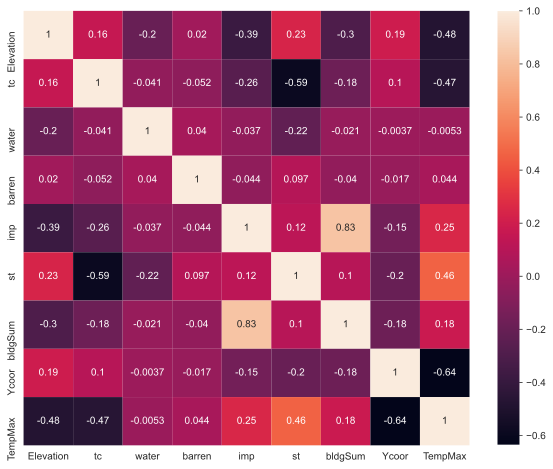

In [9]:
sns.set_style("whitegrid")

plt.figure(figsize=(10,8))

sns.heatmap(((dfTemp[['Elevation','tc','water','barren','imp','st','bldgSum','Ycoor','TempMax']]).corr()), annot=True)

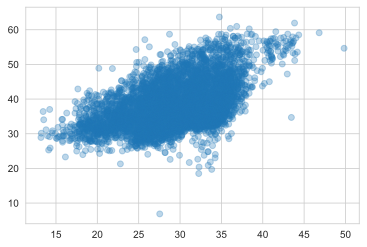

In [10]:
sns.set_style("whitegrid")

plt.scatter(dfTemp['TempMax'],dfTemp['st'],alpha=0.3)

In [7]:
with rasterio.open(tc_Address) as rst_tc:
            kwds = rst_tc.meta.copy()
            mainRasterBnd=rst_tc.bounds
            cellSize= kwds['transform'][0]

In [11]:
features_airModel_us = ['st','bldgSum','Ycoor']
depVar_airModel_us = dfTemp['TempMax']
indepVar_airModel_us = sm.add_constant(dfTemp[features_airModel_us],has_constant='add')
# Fit and summarize OLS model
airModel_us = sm.OLS(depVar_airModel_us, indepVar_airModel_us)
results_airModel_us = airModel_us.fit()
print(results_airModel_us.summary())
## for prediction the following code will be used:
predict_airModel_us = results_airModel_us.get_prediction(indepVar_airModel_us)
predict_airModel_us = predict_airModel_us.summary_frame(alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:                TempMax   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     2380.
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:47:42   Log-Likelihood:                -16899.
No. Observations:                6510   AIC:                         3.381e+04
Df Residuals:                    6506   BIC:                         3.383e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.3234      0.444     90.780      0.0

In [12]:
# name field from the eaa vector
nameField='URAU_NAME'
idField='EAA_ID'
countryCode='CNTR_CODE'
kbtuField='KBTU'

In [38]:
for pol in fiona.open(eaa_vector_address):
    #for pol in fiona.open(ecoAcAreasShapefile):
    eaa_name=(pol['properties'][nameField])
    eaa_country=(pol['properties'])[countryCode]
    eaa_id=(pol['properties'][idField])
    # kbtu per sq feet for residential use per year
    kbtu=(pol['properties'][kbtuField])
#     poly_Ycoor=(pol['properties']['Y_coor'])
    poly=(shape(pol['geometry']))
    #msaPoly=[shape(pol['geometry']) for pol in fiona.open(masShapeAddress)]

    with rasterio.open(tc_Address) as rst_tc:
        kwds = rst_tc.meta.copy()
        mainRasterBnd=rst_tc.bounds
        cellSize= kwds['transform'][0]

    polyBound = poly.bounds

    # create a window parameter tuple.   
    winProcessing=findWindow(polyBound,mainRasterBnd,cellSize)
    #(row_start, row_stop), (col_start, col_stop)
    window_use=((winProcessing[0],winProcessing[1]),(winProcessing[2],winProcessing[3]))

    # set the cells that do not have the city id as np.nan. This way we are getting cells insdie the boundary only.
    with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        eaaAr=eaaAr.flatten()    
        
#     with rasterio.open(pet_address) as src:
#         pet=src.read(1, window=window_use)
#         petNoData = (src.meta.copy())['nodata']
#         pet=pet.astype('float')
#         pet=pet.flatten()
        
    with rasterio.open(tc_Address) as rst_tc:
        tc_ar=rst_tc.read(1, window=window_use)
        tcNoData = (rst_tc.meta.copy())['nodata']
        tc_ar=tc_ar.astype('float')
        #nlcd_tc_win_ar[eaaAr!=eaa_id]=np.nan
        tc_ar=tc_ar.flatten()
        kwds = rst_tc.meta.copy()
        #print ('got the nlcd-tc layer')

    with rasterio.open(lc_Address) as src:
        lc_ar=src.read(1, window=window_use)
        lcNoData = (src.meta.copy())['nodata']
        lc_ar=lc_ar.astype('float')
        #nlcd_lc[eaaAr!=eaa_id]=np.nan
        lc_ar=lc_ar.flatten()
        #print('got the nlcd-lc layer')

    with rasterio.open(st_address) as src:
        st=src.read(1, window=window_use)
        stNoData = (src.meta.copy())['nodata']
        st=st.astype('float')
        st=st.flatten()
        
  #I substituded "at" with "air" since it was causing issues as a predefined word in python      
    with rasterio.open(at_address) as src:
        air=src.read(1, window=window_use)
        airNoData = (src.meta.copy())['nodata']
        air=air.astype('float')
        air=air.flatten()
        
    with rasterio.open(dem_address) as src:
        dem=src.read(1, window=window_use)
        demNoData = (src.meta.copy())['nodata']
        dem=dem.astype('float')
        dem=dem.flatten()
    
    with rasterio.open(bldgSum_address) as src:
        bldgSum = src.read(1,window=window_use)
        bldgNodata = (src.meta.copy())['nodata']
        bldgSum = bldgSum.astype('float')
        bldgSum = bldgSum.flatten()
        
    allArrays=np.dstack((tc_ar,lc_ar,st,air,eaaAr,bldgSum,dem))
    allArrays=allArrays[0,:,:]

    df=pd.DataFrame(allArrays,columns=['tc','lc','st','air','eaaAr','bldgSum','elevation'])

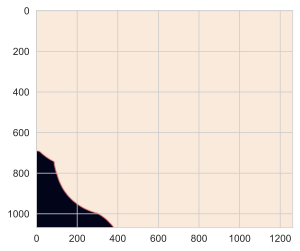

In [39]:
 with rasterio.open(dem_address) as src:
        dem = src.read(1,window=window_use)
        plt.imshow(dem)

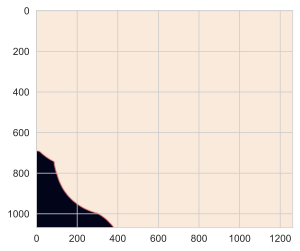

In [15]:
ar_test = np.array(df.elevation)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

In [40]:
df.head()

,tc,lc,st,air,eaaAr,bldgSum,elevation
0,63.0,311.0,3726.0,2986.0,0.0,0.0,175.0
1,74.0,311.0,3741.0,2986.0,0.0,0.0,180.0
2,74.0,311.0,3741.0,2986.0,0.0,0.0,181.0
3,74.0,311.0,3754.0,2985.0,0.0,0.0,180.0
4,69.0,311.0,3796.0,2985.0,0.0,0.0,180.0


In [41]:
df['Ycoor']= 41.9

In [42]:
#let's change nodata to np.nan
df.loc[df['air']==airNoData, 'air'] = np.nan
df.loc[df['st']==stNoData, 'st'] = np.nan
df.loc[df['lc']==lcNoData, 'lc'] = np.nan
df.loc[df['tc']==tcNoData, 'tc'] = np.nan
df.loc[df['eaaAr']==eaaNoData, 'eaaAr'] = np.nan
df.loc[df['bldgSum']==bldgNodata, 'bldgSum'] = np.nan
df.loc[df['elevation']==demNoData, 'elevation'] = np.nan
# df.loc[df['pet']==petNoData, 'pet'] = np.NaN
df.loc[df['st']<10, 'st'] = np.nan

In [43]:
#now let's set to np.nan all the data outside the area of interest, so all the rasters will be equal when performing the regressions
df.loc[df['eaaAr']!= 1, 'air'] = np.nan
df.loc[df['eaaAr']!= 1, 'st'] = np.nan
df.loc[df['eaaAr']!= 1, 'lc'] = np.nan
df.loc[df['eaaAr']!= 1, 'tc'] = np.nan
df.loc[df['eaaAr']!= 1, 'air'] = np.nan
df.loc[df['eaaAr']!= 1, 'bldgSum'] = np.nan
df.loc[df['eaaAr']!= 1, 'elevation'] = np.nan
# df.loc[df['eaaAr']!= 1, 'pet'] = np.NaN

In [44]:
dfsub=df[((df.eaaAr>0)&(df.st>0)&(df.tc>=0)&(df.air>0)&(df.bldgSum>=0))]

In [22]:
np.NaN in df['eaaAr'].values
df['air'][df.air == np.NaN], np.NaN in df.air.values

(Series([], Name: air, dtype: float64), False)

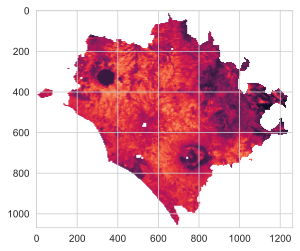

In [23]:
ar_test = np.array(df.st)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

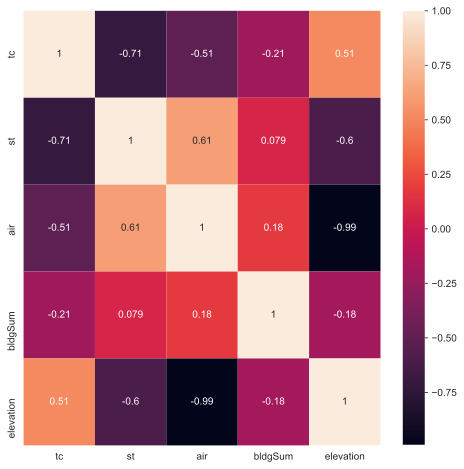

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','air','bldgSum','elevation']]).corr()), annot=True)

In [45]:
dfsub['st']=dfsub['st']/100;
dfsub['air']=dfsub['air']/100;
dfsub['bldgSum']=dfsub['bldgSum']/100;
# df['pet']=df['pet']/100

C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

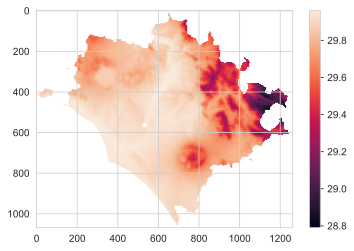

In [26]:
ar_test = np.array(df.air)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

## tc + e1 ---> st + e2 ----> at + f(e1,e2)

In [46]:
#modeling st from tc. Adding more variables (elevation, distance from vwater bodies, albedo) should improve the fit, but a traceback occurs when we run "predict_air_tc0"
dfsub['tc0']=0
features_st_model = ['tc']
depVar_st_model = dfsub['st']
indepVar_st_model = sm.add_constant(dfsub[features_st_model],has_constant='add')
st_model = sm.OLS(depVar_st_model, indepVar_st_model,missing='drop')
results_st_model = st_model.fit()
print(results_st_model.summary())

# now lets record the estimated ST
predict_st = results_st_model.get_prediction(indepVar_st_model)
predict_st = predict_st.summary_frame(alpha=0.05)
dfsub['estimated_st'] = predict_st['mean']

C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 6.120e+05
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:04:22   Log-Likelihood:            -1.5941e+06
No. Observations:              615389   AIC:                         3.188e+06
Df Residuals:                  615387   BIC:                         3.188e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.5459      0.005   8028.323      0.0

C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [47]:
# now let's see what whould be ST wit TC0
features_st_model_tc0 = ['tc0']
indepVar_st_model_tc0 = sm.add_constant(dfsub[features_st_model_tc0],has_constant='add')
predict_st_tc0 = results_st_model.get_prediction(indepVar_st_model_tc0)
predict_st_tc0 = predict_st_tc0.summary_frame(alpha=0.05)

# create a col that shows the estiamted st when tc is 0
dfsub['estimated_st_tc0'] = predict_st_tc0['mean']



C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
dfsub.sample(2)

,tc,lc,st,air,eaaAr,bldgSum,elevation,Ycoor,tc0,estimated_st,estimated_st_tc0
522216,75.0,311.0,33.85,29.50,1.0,0.00,598.0,41.9,0,36.977952,43.545929
945860,0.0,242.0,42.59,29.87,1.0,1890.48,131.0,41.9,0,43.545929,43.545929


## This is the US Model

In [66]:
features_airModel_us = ['st','Ycoor']
depVar_airModel_us = dfTemp['TempMax']
indepVar_airModel_us = sm.add_constant(dfTemp[features_airModel_us],has_constant='add')
# Fit and summarize OLS model
airModel_us = sm.OLS(depVar_airModel_us, indepVar_airModel_us)
results_airModel_us = airModel_us.fit()
print(results_airModel_us.summary())
## for prediction the following code will be used:
predict_airModel_us = results_airModel_us.get_prediction(indepVar_airModel_us)
predict_airModel_us = predict_airModel_us.summary_frame(alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:                TempMax   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     3545.
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:10:51   Log-Likelihood:                -16911.
No. Observations:                6510   AIC:                         3.383e+04
Df Residuals:                    6507   BIC:                         3.385e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6332      0.441     92.239      0.0

In [72]:
features_at_model =  ['st','Ycoor']
indepVar_air_model = sm.add_constant(dfsub[features_at_model],has_constant='add')
predict_at = results_airModel_us.get_prediction(indepVar_air_model)
predict_at = predict_at.summary_frame(alpha=0.05)
dfsub['estimated_air'] = predict_at['mean']


# now let's estiamte air temperature from esitmated_st_tc0
features_at_model_tc0 = ['estimated_st_tc0','Ycoor']
indepVar_air_model_tc0 = sm.add_constant(dfsub[features_at_model_tc0],has_constant='add')

#why do we get the prediction for air temp from the st model? and why using st_tc0 as indep var?
predict_air_tc0 = results_airModel_us.get_prediction(indepVar_air_model_tc0)
predict_air_tc0 = predict_air_tc0.summary_frame(alpha=0.05)
# create a col that shows the estiamted st when tc is 0
dfsub['estimated_at_tc0'] = predict_air_tc0['mean']

dfsub.loc[(df.tc==0),'estimated_at_tc0'] =dfsub['estimated_air']

# now let's calculate cooling
dfsub['cooling'] = dfsub['estimated_at_tc0']-dfsub['estimated_air']

dfsub.sample(10)

C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,tc,lc,st,air,eaaAr,bldgSum,elevation,Ycoor,tc0,estimated_st,estimated_st_tc0,estimated_air,estimated_at_tc0,cooling
890319,0.0,211.0,47.22,29.88,1.0,0.00,92.0,41.9,0,43.545929,43.545929,30.773362,30.773362,0.000000
934284,0.0,211.0,39.81,29.95,1.0,0.00,1.0,41.9,0,43.545929,43.545929,28.869033,28.869033,0.000000
702158,46.0,112.0,44.27,29.91,1.0,0.00,78.0,41.9,0,39.517569,43.545929,30.015229,29.829146,-0.186082
578191,0.0,242.0,42.67,29.94,1.0,0.00,32.0,41.9,0,43.545929,43.545929,29.604037,29.604037,0.000000
362797,44.0,242.0,49.92,29.89,1.0,0.00,115.0,41.9,0,39.692716,43.545929,31.467248,29.829146,-1.638101
944968,0.0,112.0,42.86,29.78,1.0,899.11,234.0,41.9,0,43.545929,43.545929,29.652866,29.652866,0.000000
857576,0.0,221.0,44.57,29.86,1.0,683.89,138.0,41.9,0,43.545929,43.545929,30.092327,30.092327,0.000000
689957,85.0,243.0,33.24,29.45,1.0,0.00,779.0,41.9,0,36.102221,43.545929,27.180579,29.829146,2.648567
940749,0.0,243.0,45.34,29.92,1.0,0.00,39.0,41.9,0,43.545929,43.545929,30.290213,30.290213,0.000000
825774,0.0,211.0,42.97,29.95,1.0,1046.23,0.0,41.9,0,43.545929,43.545929,29.681136,29.681136,0.000000


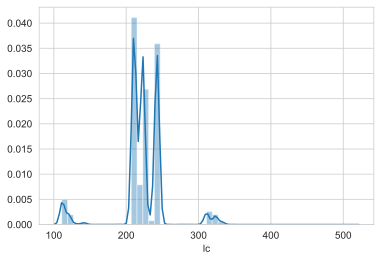

In [81]:
sns.distplot(dfsub[dfsub.cooling<0]['lc'])

In [76]:
dfsub.cooling.min()

-2.804856262443831

# check before use

In [41]:
df.loc[(~((df.estimated_st>0)|(df.estimated_air>0))),'cooling']=np.NaN

In [102]:
dfsub.cooling.mean()

-0.0006515313678849221

In [73]:
features_at_model = ['st']
indepVar_air_model = sm.add_constant(dfSample[['estimated_at_tc0']],has_constant='add')
predict_at_sample = results_at_model.get_prediction(indepVar_air_model)
predict_at_sample2 = predict_at_sample.summary_frame(alpha=0.05)

In [75]:
len(predict_at_sample2)

178952

In [81]:
dfSample

,tc,lc,st,air,eaaAr,bldgSum,elevation,tc0,estimated_st,estimated_st_tc0,estimated_air,estimated_at_tc0,cooling,estimated_st0,estimated_st00,sample
57441,0.0,211.0,43.56,29.76,1.0,0.0,249.0,0,43.545929,43.545929,29.843932,29.843539,-0.000394,29.843539,29.843539,29.459994
58703,0.0,211.0,44.27,29.76,1.0,0.0,249.0,0,43.545929,43.545929,29.863806,29.843539,-0.020268,29.843539,29.843539,29.459994
58717,0.0,223.0,43.76,29.77,1.0,0.0,347.0,0,43.545929,43.545929,29.849531,29.843539,-0.005992,29.843539,29.843539,29.459994
59965,0.0,211.0,44.64,29.76,1.0,0.0,250.0,0,43.545929,43.545929,29.874163,29.843539,-0.030624,29.843539,29.843539,29.459994
59966,0.0,211.0,43.56,29.80,1.0,0.0,227.0,0,43.545929,43.545929,29.843932,29.843539,-0.000394,29.843539,29.843539,29.459994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304338,0.0,211.0,44.45,29.89,1.0,0.0,49.0,0,43.545929,43.545929,29.868844,29.843539,-0.025306,29.843539,29.843539,29.459994
1304339,0.0,211.0,43.76,29.89,1.0,0.0,50.0,0,43.545929,43.545929,29.849531,29.843539,-0.005992,29.843539,29.843539,29.459994
1305597,0.0,211.0,43.85,29.89,1.0,0.0,52.0,0,43.545929,43.545929,29.852050,29.843539,-0.008511,29.843539,29.843539,29.459994
1320751,22.0,211.0,43.96,29.90,1.0,0.0,57.0,0,41.619322,43.545929,29.855129,29.843539,-0.011590,29.789611,29.789611,29.459994


In [78]:
dfSample

,tc,lc,st,air,eaaAr,bldgSum,elevation,tc0,estimated_st,estimated_st_tc0,estimated_air,estimated_at_tc0,cooling,estimated_st0,estimated_st00,sample
57441,0.0,211.0,43.56,29.76,1.0,0.0,249.0,0,43.545929,43.545929,29.843932,29.843539,-0.000394,29.843539,29.843539,29.459994
58703,0.0,211.0,44.27,29.76,1.0,0.0,249.0,0,43.545929,43.545929,29.863806,29.843539,-0.020268,29.843539,29.843539,29.459994
58717,0.0,223.0,43.76,29.77,1.0,0.0,347.0,0,43.545929,43.545929,29.849531,29.843539,-0.005992,29.843539,29.843539,29.459994
59965,0.0,211.0,44.64,29.76,1.0,0.0,250.0,0,43.545929,43.545929,29.874163,29.843539,-0.030624,29.843539,29.843539,29.459994
59966,0.0,211.0,43.56,29.80,1.0,0.0,227.0,0,43.545929,43.545929,29.843932,29.843539,-0.000394,29.843539,29.843539,29.459994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304338,0.0,211.0,44.45,29.89,1.0,0.0,49.0,0,43.545929,43.545929,29.868844,29.843539,-0.025306,29.843539,29.843539,29.459994
1304339,0.0,211.0,43.76,29.89,1.0,0.0,50.0,0,43.545929,43.545929,29.849531,29.843539,-0.005992,29.843539,29.843539,29.459994
1305597,0.0,211.0,43.85,29.89,1.0,0.0,52.0,0,43.545929,43.545929,29.852050,29.843539,-0.008511,29.843539,29.843539,29.459994
1320751,22.0,211.0,43.96,29.90,1.0,0.0,57.0,0,41.619322,43.545929,29.855129,29.843539,-0.011590,29.789611,29.789611,29.459994


In [54]:
df[df['cooling']<0]

,tc,lc,st,air,eaaAr,bldgSum,elevation,tc0,estimated_st,estimated_st_tc0,estimated_air,estimated_at_tc0,cooling
57441,0.0,211.0,43.56,29.76,1.0,0.0,249.0,0,43.545929,43.545929,29.843932,29.843539,-0.000394
58703,0.0,211.0,44.27,29.76,1.0,0.0,249.0,0,43.545929,43.545929,29.863806,29.843539,-0.020268
58717,0.0,223.0,43.76,29.77,1.0,0.0,347.0,0,43.545929,43.545929,29.849531,29.843539,-0.005992
59965,0.0,211.0,44.64,29.76,1.0,0.0,250.0,0,43.545929,43.545929,29.874163,29.843539,-0.030624
59966,0.0,211.0,43.56,29.80,1.0,0.0,227.0,0,43.545929,43.545929,29.843932,29.843539,-0.000394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304338,0.0,211.0,44.45,29.89,1.0,0.0,49.0,0,43.545929,43.545929,29.868844,29.843539,-0.025306
1304339,0.0,211.0,43.76,29.89,1.0,0.0,50.0,0,43.545929,43.545929,29.849531,29.843539,-0.005992
1305597,0.0,211.0,43.85,29.89,1.0,0.0,52.0,0,43.545929,43.545929,29.852050,29.843539,-0.008511
1320751,22.0,211.0,43.96,29.90,1.0,0.0,57.0,0,41.619322,43.545929,29.855129,29.843539,-0.011590


In [52]:
((df.loc[(df.cooling>=0)]).cooling.min())

0.00016594858606922003

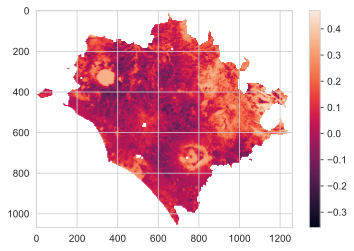

In [50]:
ar_test = np.array(df.cooling)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

In [123]:
#checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = results_st_model.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[1.7389616669343806, 1.0000000000000384]

In [18]:
np.array(vif).mean()

1.6677176150596218

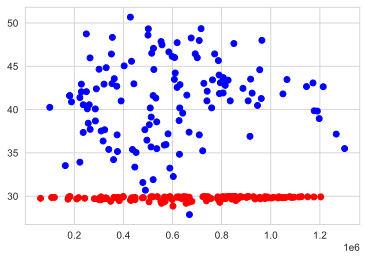

43.54592862760175

In [186]:
plt.plot(df['air'].sample(250),marker='o',color='red',linestyle='None')
plt.plot(df['st'].sample(250),marker='o',color='blue',linestyle='None')
plt.show()

df.estimated_st.max()

In [189]:
df.estimated_air.min(), df.estimated_air.max()

(29.56633531360795, 29.85811129041854)

In [178]:
df['cooling'].max()

0.32026892128134676

In [158]:
df['propagated_error']=np.sqrt((np.square(df['err_st']/df['estimated_st']))*2 + (np.square(df['err_air']/df['estimated_air']))*2)
#error of air temperature estimated

In [97]:
df_dropped= df.dropna()

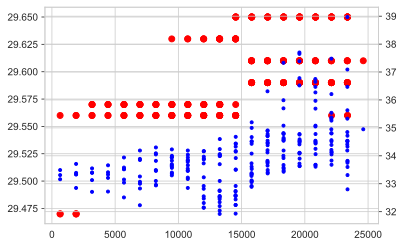

In [140]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df_dropped['air'].head(250), marker='o',color='red',linestyle='None')
ax2.plot(df_dropped['st'].head(250),  marker='.',color='blue',linestyle='None')

plt.show()

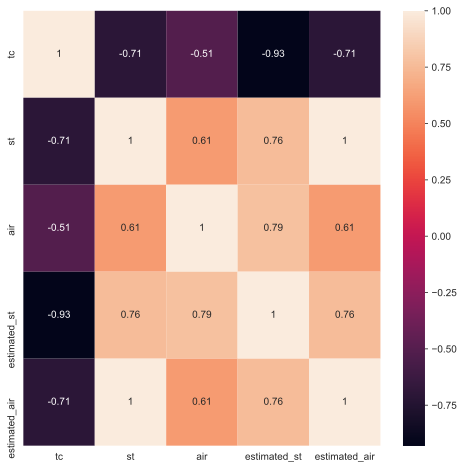

In [159]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','air','estimated_st','estimated_air']]).corr()), annot=True)

In [171]:
df['coolingst'] = df['estimated_st_tc0']-df['estimated_st']
df['coolingst'].mean()

2.1146058834204267

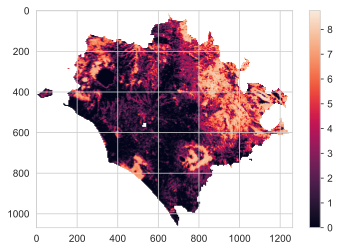

In [131]:
ar_test = np.array(df.coolingst)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

In [132]:
#writing the rasters

with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        profile=src.profile
        
cooling = np.array(df.cooling)
cooling=cooling.reshape(kwds['height'],kwds['width'])

outputFolder=r''

coolingtowriteraster     = outputFolder +r'C:\Users\nauti\EU_JRC_Urban_Heat_Mitigation\Rasters\cooling.img'

ardatatype='float64'

cooling= (cooling).astype(ardatatype)
profile['dtype']=ardatatype

with rasterio.open(coolingtowriteraster, 'w', **profile) as output:
    output.write_band(1,cooling)

In [133]:
est_st=np.array(df.estimated_st)
est_st=est_st.reshape(kwds['height'],kwds['width'])

outputFolder=r''

est_sttowriteraster     = outputFolder +r'C:\Users\nauti\EU_JRC_Urban_Heat_Mitigation\Rasters\estimated_st.img'

ardatatype='float64'

est_st= (est_st).astype(ardatatype)
profile['dtype']=ardatatype

with rasterio.open(est_sttowriteraster, 'w', **profile) as output:
    output.write_band(1,est_st)

In [134]:
est_at=np.array(df.estimated_air)
est_at=est_at.reshape(kwds['height'],kwds['width'])

outputFolder=r''

est_attowriteraster     = outputFolder +r'C:\Users\nauti\EU_JRC_Urban_Heat_Mitigation\Rasters\estimated_at.img'

ardatatype='float64'

est_at= (est_at).astype(ardatatype)
profile['dtype']=ardatatype

with rasterio.open(est_attowriteraster, 'w', **profile) as output:
    output.write_band(1,est_at)